In [17]:
from Regression import Regression
from Franke import FrankeCentered, FrankeCenteredNoise

import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn
from sklearn.metrics import mean_squared_error as MSE
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split, KFold
from sklearn.linear_model import Lasso
import skimage.measure
import scipy.stats
import time
from imageio import imread
from tqdm import tqdm, trange

mpl.style.use("seaborn-darkgrid")
mpl.rcParams["image.cmap"] = "gnuplot2"
mpl.rcParams['figure.figsize'] = [6.0, 6.0]
mpl.rcParams["xtick.labelsize"] = 18
mpl.rcParams["ytick.labelsize"] = 18

mpl.rcParams['font.size'] = 18
#mpl.rcParams['legend.fontsize'] = 'large'
#mpl.rcParams['figure.titlesize'] = 'medium'

np.random.seed(1942)

# Franke Data

# beta conf interval

In [2]:
x, y = np.linspace(-1, 1, 101), np.linspace(-1, 1, 101)
reg = Regression()
reg.generate_generic_data(x, y, FrankeCenteredNoise)

In [3]:
X = reg.get_X(reg.x_flat, reg.y_flat, 5)

df = X.shape[0]*X.shape[1] - 1

XTX_diag = np.diagonal(np.linalg.pinv(X.T@X))

data_pred = reg.solveKFold(store_beta=True)
beta = reg.beta
sigma_estimate2 = 1/(X.shape[0] - X.shape[1] - 1)*np.sum((data_pred - reg.f)**2)
sigma_beta = np.sqrt(XTX_diag*sigma_estimate2)
S_beta = np.linalg.pinv(X.T@X)

t_05 = scipy.stats.t.cdf(0.05, df)
beta_cf = np.zeros((len(XTX_diag), 2))
beta_err = t_05*sigma_beta
beta_cf[:,0] = beta - t_05*sigma_beta
beta_cf[:,1] = beta + t_05*sigma_beta

In [4]:
sigma_beta

array([0.02732368, 0.09037554, 0.11986586, 0.29563379, 0.12521187,
       0.24700432, 0.09037554, 0.09890648, 0.23403953, 0.10921349,
       0.21473658, 0.11986586, 0.23403953, 0.10721922, 0.2094381 ,
       0.29563379, 0.10921349, 0.2094381 , 0.12521187, 0.21473658,
       0.24700432])

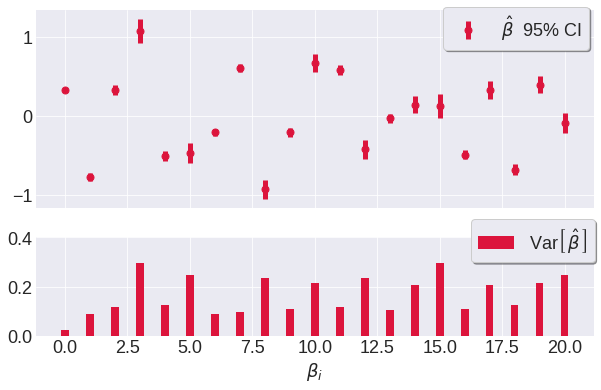

In [18]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10,6), sharex=True, gridspec_kw={'height_ratios': [2, 1]})
asdf = np.arange(0, len(beta))
ax1.errorbar(asdf, beta, yerr=beta_err, fmt="o", ms=7, elinewidth=5, color="crimson", label=r"$\hat{\beta}$  95% CI");
plt.xlabel(r"$\beta_i$")
ax2.bar(asdf, sigma_beta, width=0.3, color="crimson", label=r"Var$\left[\, \hat{\beta}\, \right]$");
ax2.set_ylim(0, 0.4);
ax1.legend(shadow=True, frameon=True, fontsize=18, loc=(0.73, 0.8));
ax2.legend(shadow=True, frameon=True, fontsize=18, loc=(0.78, 0.75));
plt.savefig("../figs/CI_Franke.pdf", bbox_inches="tight")

In [6]:
nr_bootstraps = 1000
nr_parameters = sigma_beta.size
beta_bootstrap = np.zeros((nr_bootstraps, nr_parameters))
for i in range(nr_parameters):
    beta_bootstrap[:,i] = np.random.normal(beta[i], sigma_beta[i], nr_bootstraps)


In [7]:
franke_bootstraps = np.zeros((nr_bootstraps, 101, 101))
for i in trange(nr_bootstraps):
    franke_bootstraps[i,:,:] = reg.apply_model(beta_bootstrap[i], reg.x_mesh, reg.y_mesh)

100%|██████████| 1000/1000 [00:03<00:00, 326.26it/s]


In [8]:
franke_std = np.std(franke_bootstraps, axis=0)

0.02794208471088134

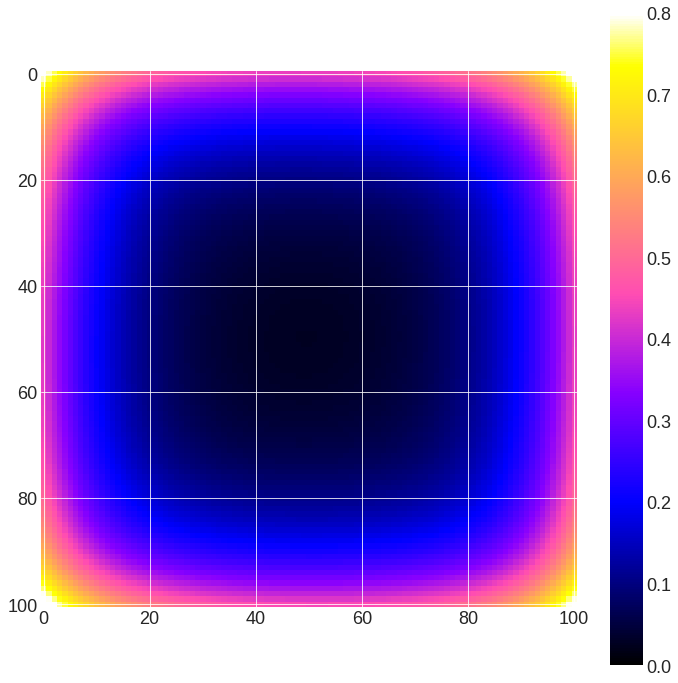

In [9]:
plt.figure(figsize=(12,12))
plt.imshow(franke_std, vmin=0, vmax=0.8, cmap="gnuplot2")
plt.colorbar()
franke_std.min()

In [10]:
franke_CI95_min = data_pred - t_05*franke_std
franke_CI95_max = data_pred + t_05*franke_std

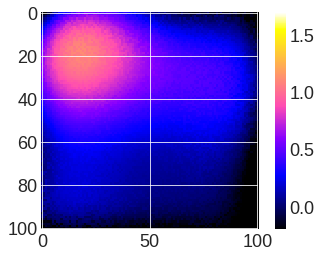

In [11]:
plt.imshow(franke_CI95_min, vmin=-0.2, vmax=1.7)
plt.colorbar()

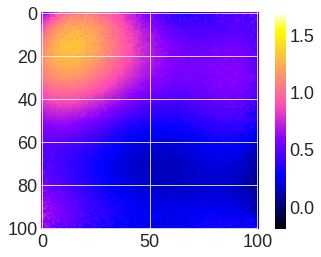

In [12]:
plt.imshow(franke_CI95_max, vmin=-0.2, vmax=1.7)
plt.colorbar();

# Terrain Data

In [149]:
terrain0 = imread("../input_data/SRTM_data_Norway_1.tif")/1000
terrain32 = skimage.measure.block_reduce(terrain0, (32, 32), np.mean)
reg.load_matrix_data(terrain1)

In [150]:
X = reg.get_X(reg.x_flat, reg.y_flat, 5)

df = X.shape[0]*X.shape[1] - 1

XTX_diag = np.diagonal(np.linalg.pinv(X.T@X))

data_pred = reg.solveKFold(store_beta=True)
beta = reg.beta
sigma_estimate2 = 1/(X.shape[0] - X.shape[1] - 1)*np.sum((data_pred - reg.f)**2)
sigma_beta = np.sqrt(XTX_diag*sigma_estimate2)
S_beta = np.linalg.pinv(X.T@X)

t_05 = scipy.stats.t.cdf(0.05, df)
beta_cf = np.zeros((len(XTX_diag), 2))
beta_err = t_05*sigma_beta
beta_cf[:,0] = beta - t_05*sigma_beta
beta_cf[:,1] = beta + t_05*sigma_beta

In [151]:
sigma_estimate2

0.04266824457090648

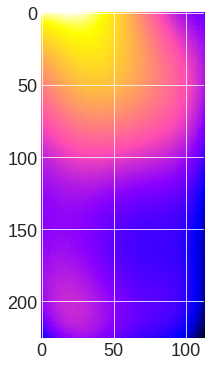

In [152]:
plt.imshow(data_pred)

In [153]:
beta_cf

array([[ 0.64954409,  0.65324858],
       [-0.68388106, -0.67156616],
       [ 0.44696783,  0.46338946],
       [ 0.82413834,  0.86483295],
       [-0.3247065 , -0.30736989],
       [-0.46395567, -0.42960048],
       [-0.10661954, -0.09435437],
       [-0.01487977, -0.00138308],
       [-0.33430568, -0.30220529],
       [ 0.20359363,  0.21865724],
       [-0.04037693, -0.0106136 ],
       [ 0.00380061,  0.02008537],
       [ 0.48732599,  0.51929498],
       [-0.0960808 , -0.08135336],
       [-0.33164671, -0.30272977],
       [ 0.12744651,  0.16764582],
       [-0.10147372, -0.086538  ],
       [ 0.17033793,  0.19913397],
       [-0.15533126, -0.13828578],
       [-0.2648146 , -0.23542131],
       [-0.17296995, -0.13931709]])

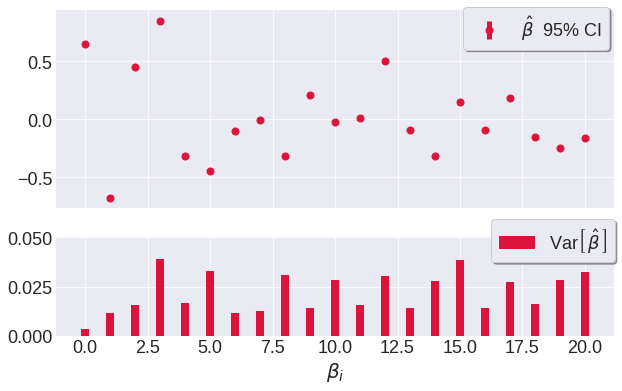

In [154]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10,6), sharex=True, gridspec_kw={'height_ratios': [2, 1]})
asdf = np.arange(0, len(beta))
ax1.errorbar(asdf, beta, yerr=beta_err, fmt="o", ms=7, elinewidth=5, color="crimson", label=r"$\hat{\beta}$  95% CI");
plt.xlabel(r"$\beta_i$")
ax2.bar(asdf, sigma_beta, width=0.3, color="crimson", label=r"Var$\left[\, \hat{\beta}\, \right]$");
ax2.set_ylim(0, 0.05);
ax1.legend(shadow=True, frameon=True, fontsize=18, loc=(0.73, 0.8));
ax2.legend(shadow=True, frameon=True, fontsize=18, loc=(0.78, 0.75));
plt.savefig("../figs/CI_Terrain.pdf", bbox_inches="tight")

In [ ]:
nr_bootstraps = 100
nr_parameters = sigma_beta.size
beta_bootstrap = np.zeros((nr_bootstraps, nr_parameters))
for i in trange(nr_parameters):
    beta_bootstrap[:,i] = np.random.normal(beta[i], sigma_beta[i], nr_bootstraps)

In [ ]:
franke_bootstraps = np.zeros((nr_bootstraps, terrain1.shape[0], terrain1.shape[1]))
for i in trange(nr_bootstraps):
    franke_bootstraps[i,:,:] = reg.apply_model(beta_bootstrap[i], reg.x_mesh, reg.y_mesh)

In [ ]:
franke_std = np.std(franke_bootstraps, axis=0)

In [ ]:
plt.figure(figsize=(12,12))
plt.imshow(franke_std)#, vmin=0, vmax=0.8, cmap="gnuplot2")
plt.colorbar()
franke_std.min()